In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from scipy import stats
from windrose import WindroseAxes
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_csv('../data/togo-dapaong_qc.csv')

In [4]:
# Summary Statistics & Missing-Value Report

def summarize_and_check_missing(df, threshold=5):
    """
    Generate summary statistics and a missing value report for a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        threshold (float): Percentage threshold to flag high-null columns (default: 5%).
    
    Returns:
        dict: Dictionary with 'numeric_summary', 'missing_report', 'high_null_columns'
    """
    
    # 1. Summary Statistics
    numeric_summary = df.describe(include='number')
    print("Summary Statistics (Numeric Columns):")
    display(numeric_summary)
    
    # 2. Missing Values Report
    missing_counts = df.isna().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    missing_report = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing %': missing_percentage.round(2)
    })
    
    print("\nMissing Values:")
    display(missing_report)
    
    # 3. High Null Columns
    high_null_cols = missing_percentage[missing_percentage > threshold].index.tolist()
    print(f"\nColumns with >{threshold}% Missing Values:", high_null_cols if high_null_cols else "None!")
    
    return {
        'numeric_summary': numeric_summary,
        'missing_report': missing_report,
        'high_null_columns': high_null_cols
    }
    
results = summarize_and_check_missing(df)

Summary Statistics (Numeric Columns):


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
std,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN
min,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN



Missing Values:


,Missing Count,Missing %
Timestamp,0,0.0
GHI,0,0.0
DNI,0,0.0
DHI,0,0.0
ModA,0,0.0
ModB,0,0.0
Tamb,0,0.0
RH,0,0.0
WS,0,0.0
WSgust,0,0.0



Columns with >5% Missing Values: ['Comments']


In [5]:
#Outlier Detection & Basic Cleaning

def detect_and_cap_outliers(df, columns, z_thresh=3, lower_q=0.01, upper_q=0.99):
    """
    Detect and cap outliers in given columns using Z-score and quantile clipping.
    """
    for col in columns:
        z_scores = np.abs(stats.zscore(df[col], nan_policy='omit'))
        outliers = z_scores > z_thresh
        print(f"\n{col} - Outliers Detected: {outliers.sum()} ({(outliers.sum() / len(df)) * 100:.2f}%)")
        
        # Cap outliers using quantiles
        lower_bound = df[col].quantile(lower_q)
        upper_bound = df[col].quantile(upper_q)
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        print(f"Capped {col} to range: {lower_bound:.2f} - {upper_bound:.2f}")
        
    return df

def impute_missing_with_median(df, columns):
    """
    Fill missing values with median for selected columns.
    """
    for col in columns:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Filled missing in {col} with median = {median_val:.2f}")
    return df

def drop_outliers(df, columns, z_thresh=3):
    """
    Drop rows where Z-score is greater than threshold across specified columns.
    """
    z_scores = np.abs(stats.zscore(df[columns], nan_policy='omit'))
    filtered_df = df[(z_scores < z_thresh).all(axis=1)]
    print(f"Dropped {len(df) - len(filtered_df)} rows based on Z-score > {z_thresh}")
    return filtered_df

def export_cleaned_data(df, country, output_dir='../data'):
    """
    Save the cleaned DataFrame to a CSV file named <country>_clean.csv.
    """
    os.makedirs(output_dir, exist_ok=True)
    file_path = os.path.join(output_dir, f'{country}_clean.csv')
    df.to_csv(file_path, index=False)
    print(f"Cleaned data saved to: {file_path}")

print("Initial shape:", df.shape)

columns_to_clean = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
df = detect_and_cap_outliers(df, columns_to_clean)
df = impute_missing_with_median(df, columns_to_clean)
df = drop_outliers(df, columns_to_clean)

print("Final shape after cleaning:", df.shape)

export_cleaned_data(df, country='togo')



Initial shape: (525600, 19)

GHI - Outliers Detected: 305 (0.06%)
Capped GHI to range: -4.90 - 1006.00

DNI - Outliers Detected: 1062 (0.20%)
Capped DNI to range: 0.00 - 847.20

DHI - Outliers Detected: 3415 (0.65%)
Capped DHI to range: 0.00 - 562.50

ModA - Outliers Detected: 137 (0.03%)
Capped ModA to range: 0.00 - 988.00

ModB - Outliers Detected: 206 (0.04%)
Capped ModB to range: 0.00 - 964.00

WS - Outliers Detected: 3510 (0.67%)
Capped WS to range: 0.00 - 6.40

WSgust - Outliers Detected: 3915 (0.74%)
Capped WSgust to range: 0.00 - 8.40
Dropped 0 rows based on Z-score > 3
Final shape after cleaning: (525600, 19)
Cleaned data saved to: ../data\togo_clean.csv


Saved full time series plot to figures/togo/full_timeseries_plot.png


<Figure size 1200x800 with 0 Axes>

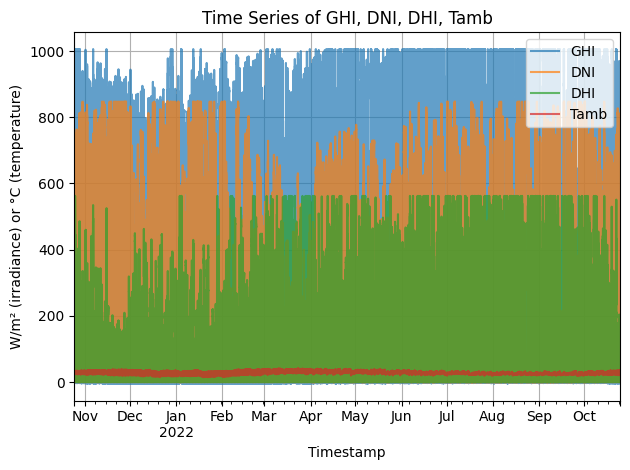

Saved monthly average trends to figures/togo/monthly_average_trends.png


<Figure size 1400x600 with 0 Axes>

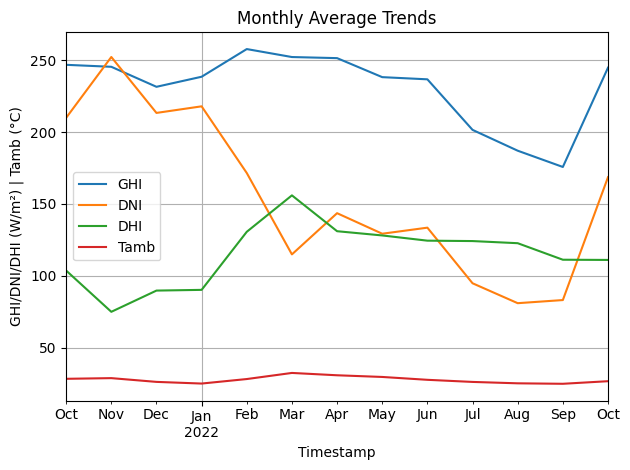

In [6]:
#Time Series Analysis

def prepare_timestamp(df, timestamp_col='Timestamp'):
    """
    Ensure the timestamp column is in datetime format and set as index.
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    return df.set_index(timestamp_col)

def plot_full_timeseries(df, variables, country):
    """
    Plot time series of selected variables.
    """
    plt.figure(figsize=(12, 8))
    df[variables].plot(alpha=0.7)
    plt.title('Time Series of ' + ', '.join(variables))
    plt.ylabel('W/m² (irradiance) or °C (temperature)')
    plt.grid(True)
    plt.tight_layout()
    save_path = f'figures/{country}/full_timeseries_plot.png'
    plt.savefig(save_path)
    print(f"Saved full time series plot to {save_path}")
    plt.show()

def plot_monthly_average(df, variables, country):
    """
    Resample data monthly and plot average values.
    """
    monthly_avg = df[variables].resample('ME').mean()
    plt.figure(figsize=(14, 6))
    monthly_avg.plot()
    plt.title('Monthly Average Trends')
    plt.ylabel('GHI/DNI/DHI (W/m²) | Tamb (°C)')
    plt.grid(True)
    plt.tight_layout()
    save_path = f'figures/{country}/monthly_average_trends.png'
    plt.savefig(save_path)
    print(f"Saved monthly average trends to {save_path}")
    plt.show()
country = 'togo'  # or 'togo', 'sierra_leone'
df = prepare_timestamp(df)

variables = ['GHI', 'DNI', 'DHI', 'Tamb']

plot_full_timeseries(df, variables, country)
plot_monthly_average(df, variables, country)


Saved cleaning impact plot to: figures/togo/model_comparison_pre_post_cleaning.png


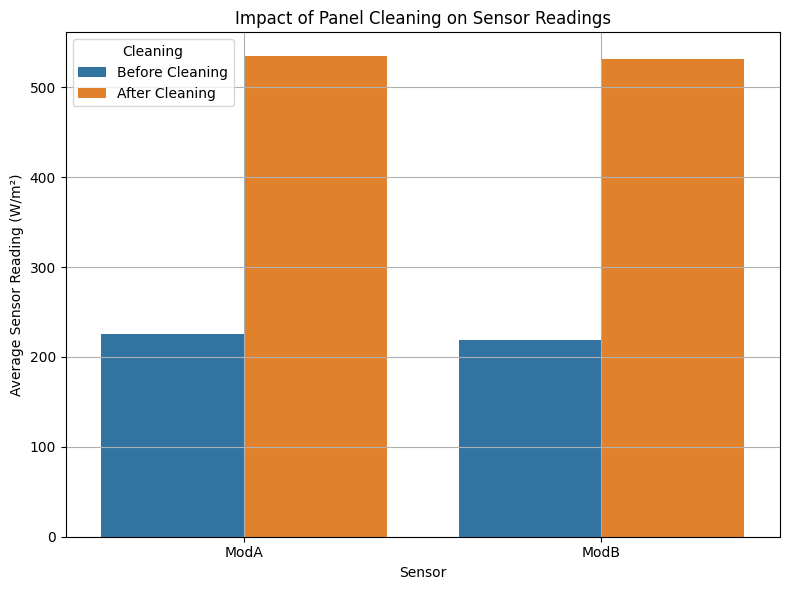

In [7]:
# Cleaning Impact
def analyze_cleaning_impact(df, country='togo', cleaning_col='Cleaning', sensor_cols=['ModA', 'ModB']):
    """
    Analyze and plot the impact of cleaning on sensor readings.
    
    Parameters:
        df (pd.DataFrame): Input dataframe with cleaning flag and sensor readings.
        country (str): Country name for saving the figure.
        cleaning_col (str): Column indicating before/after cleaning (binary).
        sensor_cols (list): Sensor columns to analyze.
    """
    if cleaning_col not in df.columns or not all(col in df.columns for col in sensor_cols):
        print("Missing required columns.")
        return

    impact = df.groupby(cleaning_col)[sensor_cols].mean().reset_index()
    impact[cleaning_col] = impact[cleaning_col].map({0: 'Before Cleaning', 1: 'After Cleaning'})

    plt.figure(figsize=(8, 6))
    sns.barplot(data=impact.melt(id_vars=cleaning_col, var_name='Sensor', value_name='Average Reading'),
                x='Sensor', y='Average Reading', hue=cleaning_col)
    
    plt.title('Impact of Panel Cleaning on Sensor Readings')
    plt.ylabel('Average Sensor Reading (W/m²)')
    plt.xlabel('Sensor')
    plt.grid(True)
    plt.tight_layout()
    
    save_path = f"figures/{country}/model_comparison_pre_post_cleaning.png"
    plt.savefig(save_path)
    print(f"Saved cleaning impact plot to: {save_path}")
    plt.show()
    
analyze_cleaning_impact(df, country='togo')


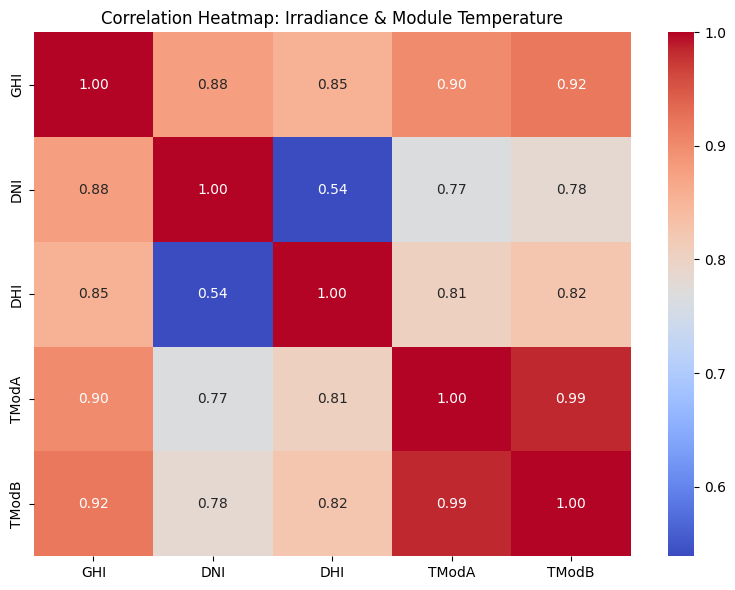

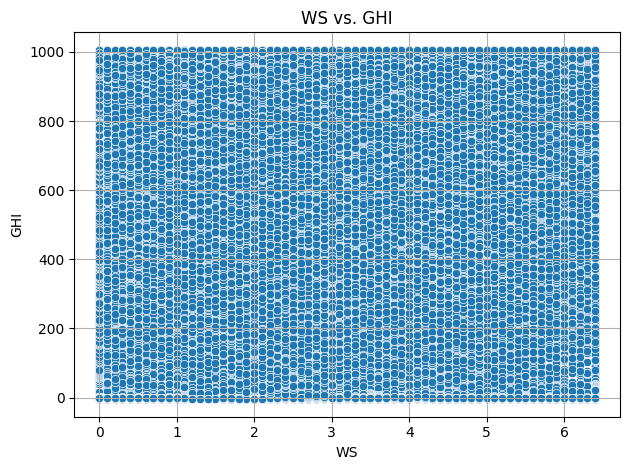

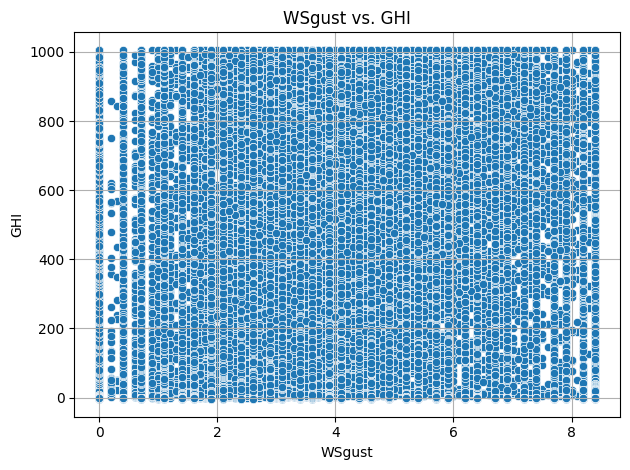

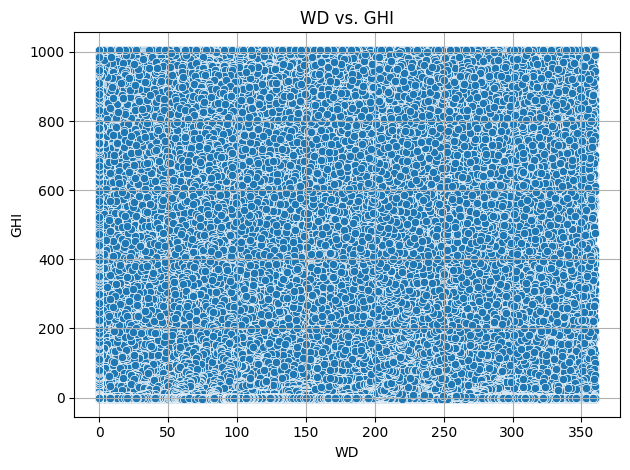

In [8]:
# Correlation & Relationship Analysis

def correlation_and_scatter_analysis(df, country='togo'):
    """
    Plots correlation heatmap and scatter plots between key meteorological variables and GHI.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        country (str): The country name used in saving file paths.
    """
    figure_dir = f'figures/{country}'
    os.makedirs(figure_dir, exist_ok=True)

    # 1. Heatmap: Irradiance vs Module Temp
    correlation_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
    corr_matrix = df[correlation_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap: Irradiance & Module Temperature")
    plt.tight_layout()
    plt.savefig(f'{figure_dir}/correlation_heatmap_irradiance_temp.png')
    plt.show()

    # 2. Scatter Plots
    scatter_pairs = {
        'WS': 'ws_vs_ghi.png',
        'WSgust': 'wsgust_vs_ghi.png',
        'WD': 'wd_vs_ghi.png'
    }

    for feature, filename in scatter_pairs.items():
        if feature in df.columns:
            plt.figure()
            sns.scatterplot(data=df, x=feature, y='GHI')
            plt.title(f'{feature} vs. GHI')
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'{figure_dir}/{filename}')
            plt.show()
        else:
            print(f"Column {feature} not found in dataframe.")
correlation_and_scatter_analysis(df, country='togo')

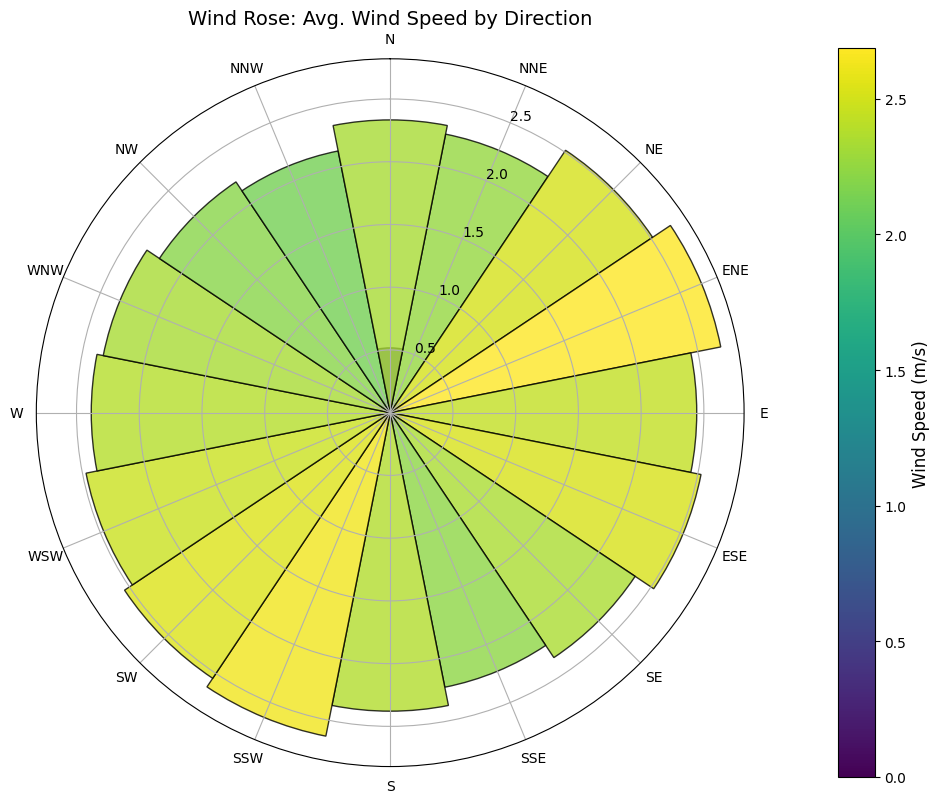

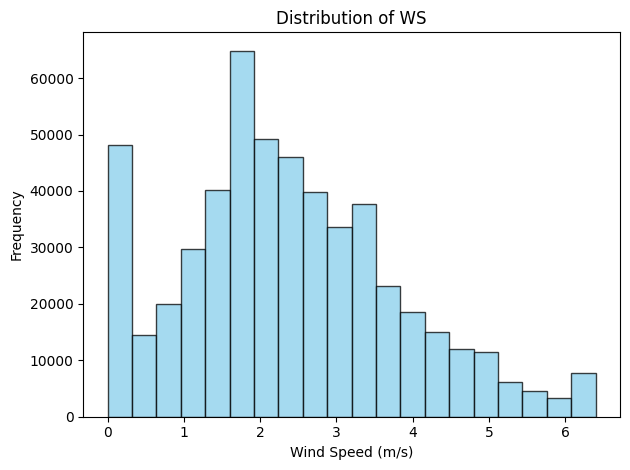

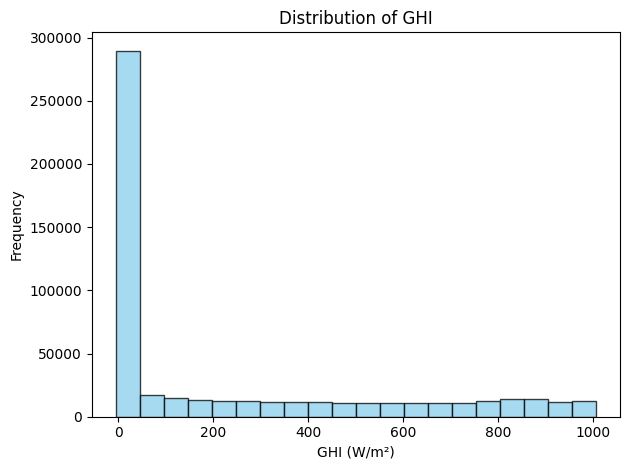

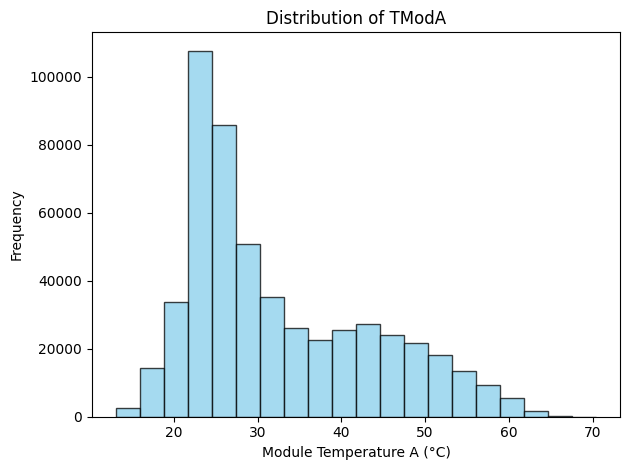

In [9]:
# Wind & Distribution Analysis

def wind_and_distribution_analysis(df, country='togo'):
    """
    Plots a radial wind rose and histograms for WS, GHI, and TModA.

    Parameters:
        df (pd.DataFrame): Cleaned dataframe.
        country (str): Country name for saving plot paths.
    """

    figure_dir = f'figures/{country}'
    os.makedirs(figure_dir, exist_ok=True)

    # ---- WIND ROSE / RADIAL PLOT ----
    try:
        # Bin wind direction into 16 sectors (22.5° each)
        df['WD_bin'] = (df['WD'] // 22.5) * 22.5
        wind_groups = df.groupby('WD_bin')['WS'].mean().reset_index()

        theta = np.radians(wind_groups['WD_bin'])
        wind_speeds = wind_groups['WS']
        width = np.radians(22.5)

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, polar=True)
        bars = ax.bar(
            theta, wind_speeds,
            width=width,
            color=plt.cm.viridis(wind_speeds / wind_speeds.max()),
            edgecolor='black', alpha=0.8
        )

        cardinals = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                     'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
        ax.set_xticks(np.radians(np.arange(0, 360, 22.5)))
        ax.set_xticklabels(cardinals, fontsize=10)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_title('Wind Rose: Avg. Wind Speed by Direction', fontsize=14)

        cbar = plt.colorbar(plt.cm.ScalarMappable(
            cmap='viridis',
            norm=plt.Normalize(0, wind_speeds.max())
        ), ax=ax, pad=0.1)
        cbar.set_label('Wind Speed (m/s)', fontsize=12)

        plt.tight_layout()
        plt.savefig(f'{figure_dir}/radial_wind_plot.png', dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print("Wind rose plot failed:", e)

    # ---- HISTOGRAMS ----
    hist_vars = {
        'WS': 'Wind Speed (m/s)',
        'GHI': 'GHI (W/m²)',
        'TModA': 'Module Temperature A (°C)'
    }

    for col, xlabel in hist_vars.items():
        if col in df.columns:
            plt.figure()
            df[col].hist(bins=20, edgecolor='black', alpha=0.75, color='skyblue')
            plt.title(f'Distribution of {col}')
            plt.xlabel(xlabel)
            plt.ylabel('Frequency')
            plt.grid(False)
            plt.tight_layout()
            plt.savefig(f'{figure_dir}/histogram_{col.lower()}.png')
            plt.show()
        else:
            print(f"Column {col} not found in DataFrame.")
wind_and_distribution_analysis(df, country='togo')


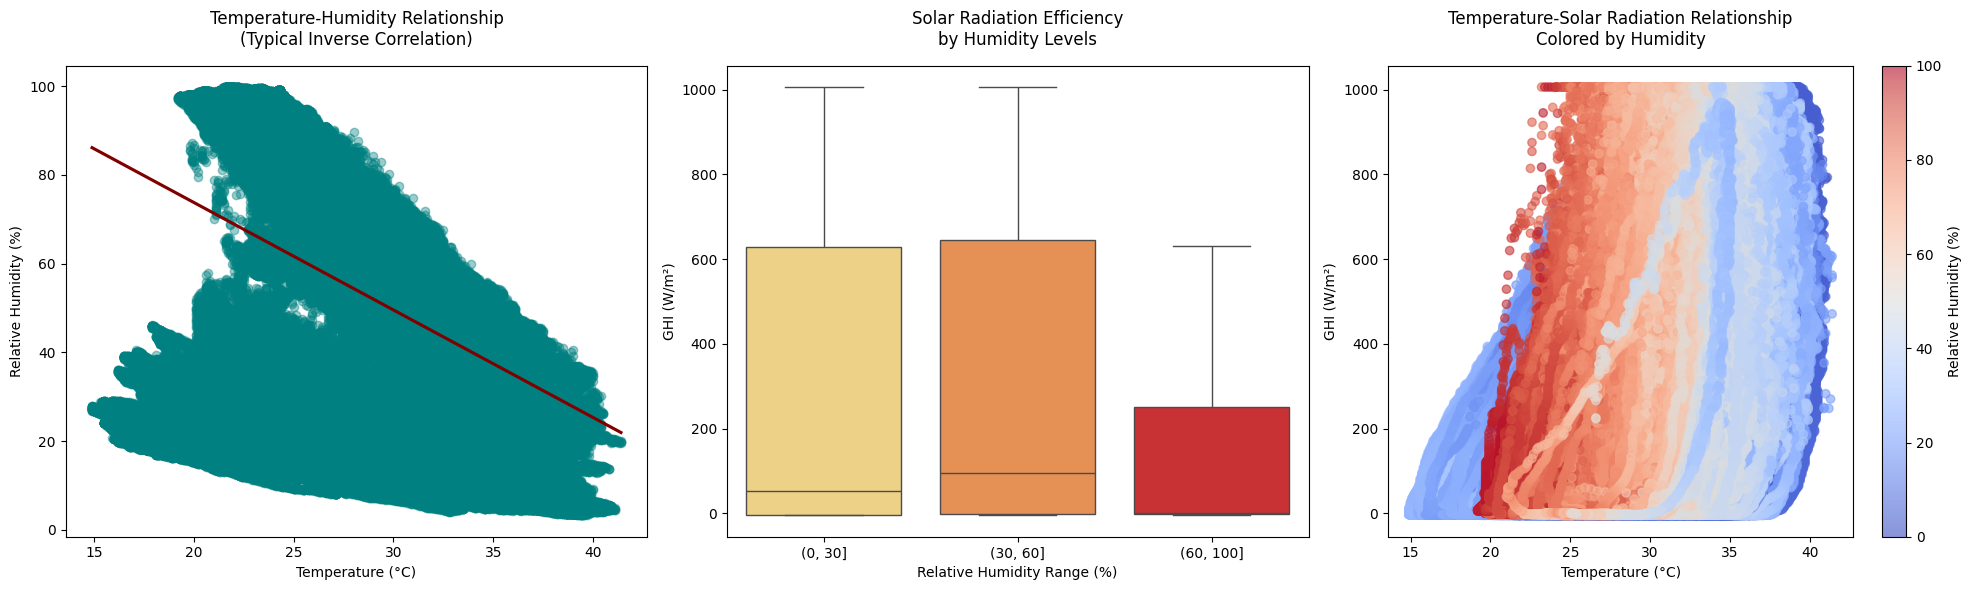

In [10]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: RH vs Temperature (unchanged)
sns.regplot(x='Tamb', y='RH', data=df, ax=ax1, 
            scatter_kws={'alpha':0.4, 'color':'teal'},
            line_kws={'color':'maroon'})
ax1.set_title('Temperature-Humidity Relationship\n(Typical Inverse Correlation)', pad=15)
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Relative Humidity (%)')

# Plot 2: RH vs GHI (fixed)
# First create the RH groups
rh_groups = pd.cut(df['RH'], bins=[0,30,60,100])

sns.boxplot(x=rh_groups, 
            y='GHI', 
            hue=rh_groups,  # Explicitly assign hue
            data=df, 
            ax=ax2,
            palette='YlOrRd', 
            showfliers=False,
            legend=False)  # Disable redundant legend
ax2.set_title('Solar Radiation Efficiency\nby Humidity Levels', pad=15)
ax2.set_xlabel('Relative Humidity Range (%)')
ax2.set_ylabel('GHI (W/m²)')

# Plot 3: Temperature vs GHI (Humidity-Weighted) (unchanged)
sc = ax3.scatter('Tamb', 'GHI', c='RH', 
                data=df, cmap='coolwarm', 
                alpha=0.6, vmin=0, vmax=100)
plt.colorbar(sc, label='Relative Humidity (%)')
ax3.set_title('Temperature-Solar Radiation Relationship\nColored by Humidity', pad=15)
ax3.set_xlabel('Temperature (°C)')
ax3.set_ylabel('GHI (W/m²)')

plt.tight_layout()
plt.savefig('figures/togo/temp_humidity_ghi_triad.png', dpi=300)
plt.show()

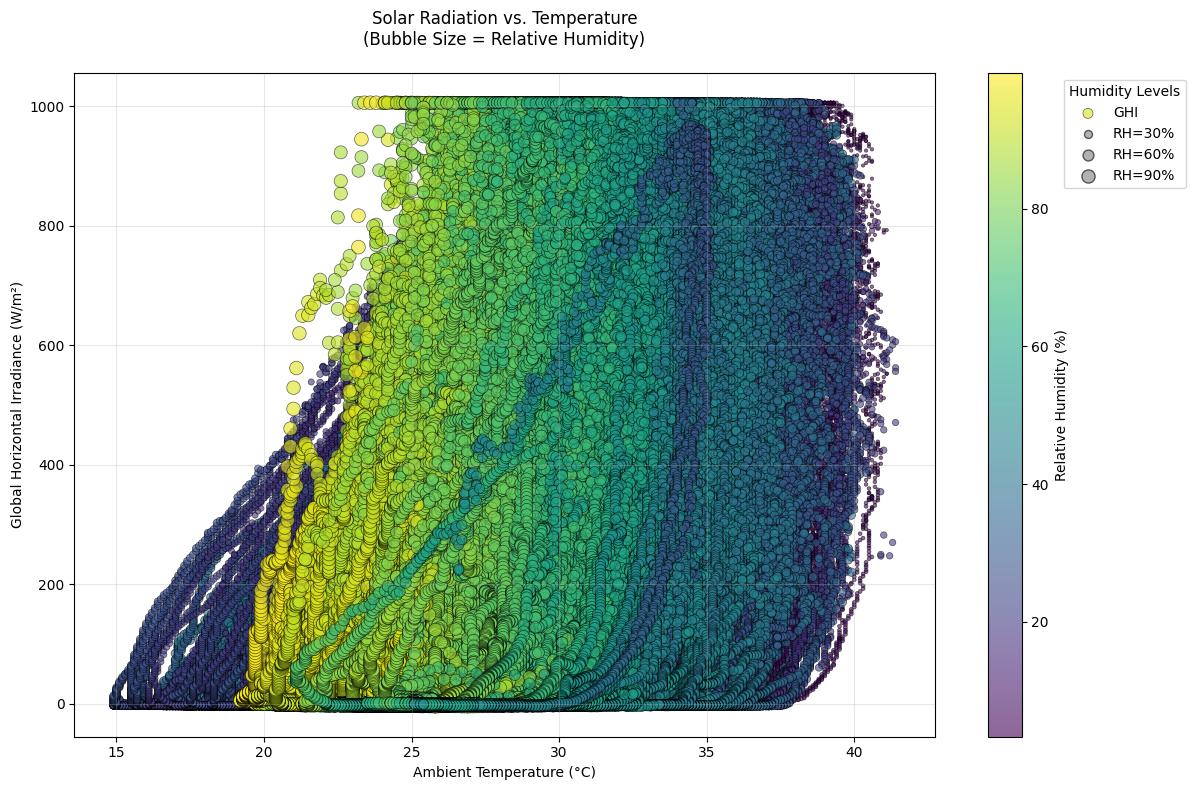

In [11]:
#  Bubble Chart: GHI vs Temperature with Humidity

plt.figure(figsize=(12, 8))

# Normalize RH for bubble sizes (5-100 point scale)
rh_size = (df['RH'] - df['RH'].min()) / (df['RH'].max() - df['RH'].min()) * 95 + 5

sc = plt.scatter(
    x='Tamb', y='GHI', s=rh_size, c='RH',
    data=df, alpha=0.6, cmap='viridis',
    edgecolors='black', linewidth=0.5
)

# Formatting
plt.title('Solar Radiation vs. Temperature\n(Bubble Size = Relative Humidity)', pad=20)
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Global Horizontal Irradiance (W/m²)')

# Add colorbar and legend
cbar = plt.colorbar(sc)
cbar.set_label('Relative Humidity (%)')

# Create bubble size legend
for rh in [30, 60, 90]:
    plt.scatter([], [], s=(rh/100)*95+5, 
                c='gray', alpha=0.6, 
                label=f'RH={rh}%', 
                edgecolors='black')
plt.legend(title='Humidity Levels', 
           bbox_to_anchor=(1.3, 1),
           frameon=True)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/togo/ghi_temp_bubble_chart.png', dpi=300, bbox_inches='tight')
plt.show()